In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
from sp4asc.datasets.dcase import DCaseDataset
import librosa
import librosa.display
import librosa.display.waveplot
%matplotlib inline

ModuleNotFoundError: No module named 'librosa.display.waveplot'; 'librosa.display' is not a package

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

### Gros Neural Network

In [19]:
%mkdir data
%cd data
!wget 
!tar -zxvf .tgz

c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE\data


Un sous-r�pertoire ou un fichier data existe d�j�.
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'tar' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [4]:
%ls

 Le volume dans le lecteur C s'appelle OS
 Le num�ro de s�rie du volume est 7475-2230

 R�pertoire de c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE\data

01/03/2022  16:38    <DIR>          .
01/03/2022  16:38    <DIR>          ..
               0 fichier(s)                0 octets
               2 R�p(s)  16�794�103�808 octets libres


In [ ]:
%cd 
%ls

#### Data Processing



In [5]:
%cd ..
data_dir = '/data'

c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE


### Creating ResNet model

In [12]:
model_resnet = models.resnet50(pretrained=False)

In [16]:
model_resnet.fc = torch.nn.Linear(in_features=2048,out_features=10)

In [17]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Data Extraction

In [33]:
%ls

 Le volume dans le lecteur C s'appelle OS
 Le num�ro de s�rie du volume est 7475-2230

 R�pertoire de c:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE

01/03/2022  16:38    <DIR>          .
01/03/2022  16:38    <DIR>          ..
01/03/2022  16:29    <DIR>          configs
01/03/2022  17:11    <DIR>          data
01/03/2022  16:29               827 Dockerfile
01/03/2022  16:29            10�339 LICENSE
01/03/2022  17:11            19�654 projet.ipynb
01/03/2022  16:29             8�166 README.md
01/03/2022  16:29               118 setup.py
01/03/2022  16:45    <DIR>          sp4asc
01/03/2022  16:29             2�838 test.py
01/03/2022  16:29             3�143 train.py
01/03/2022  16:29    <DIR>          trained_models
               7 fichier(s)           45�085 octets
               6 R�p(s)   8�944�226�304 octets libres


In [39]:
file = r"C:\Users\stanislas\Documents\GitHub\Project-Acoustic-Scene-Classification-DCASE\data\TAU-urban-acoustic-scenes-2020-mobile-development\audio\airport-paris-206-6247-b.wav"
signal, sample_rate = librosa.load(file, sr=22050)

In [51]:
type(signal[0])

numpy.float32

C:\Users\STANIS~1\AppData\Local\Temp/ipykernel_88140/3464211200.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sample_rate, alpha=0.4)


STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


C:\Users\STANIS~1\AppData\Local\Temp/ipykernel_88140/3464211200.py:69: FutureWarning: Pass y=[0.0256837  0.03651902 0.02118207 ... 0.15732946 0.15211496 0.16335754], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)


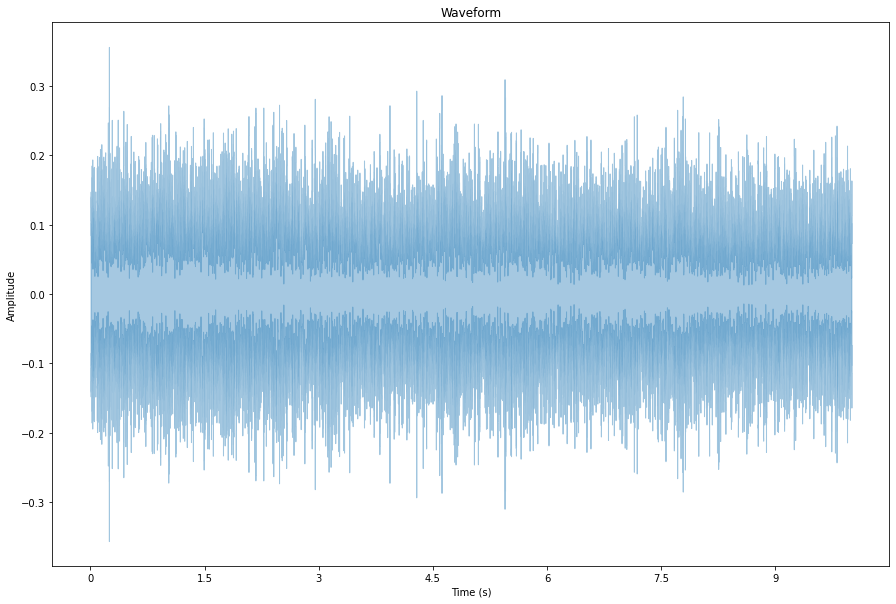

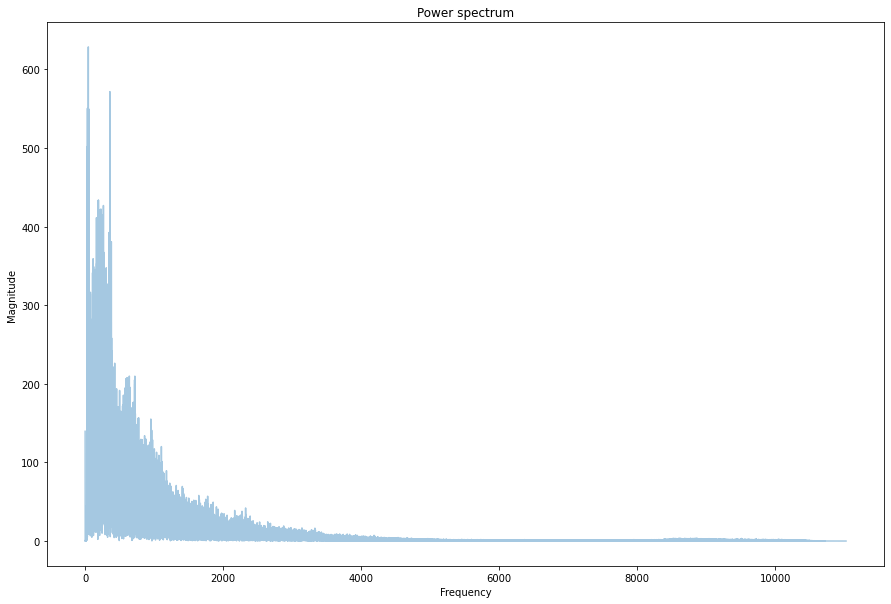

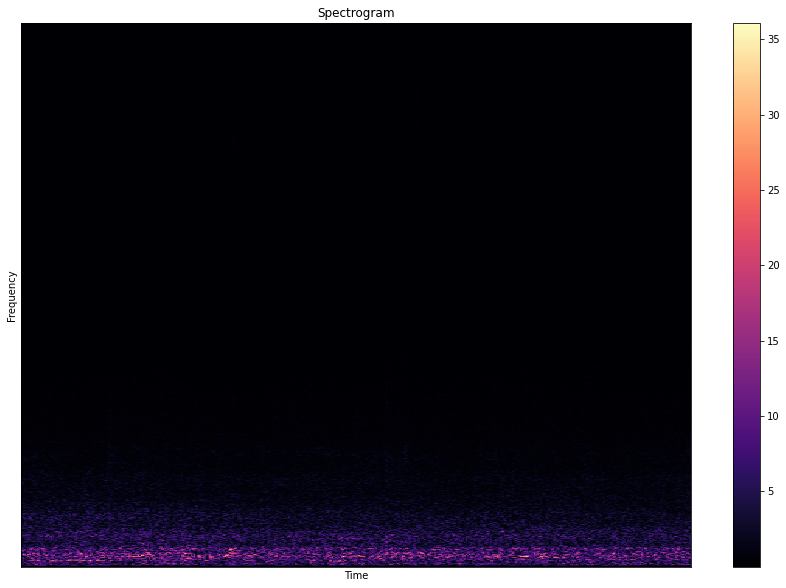

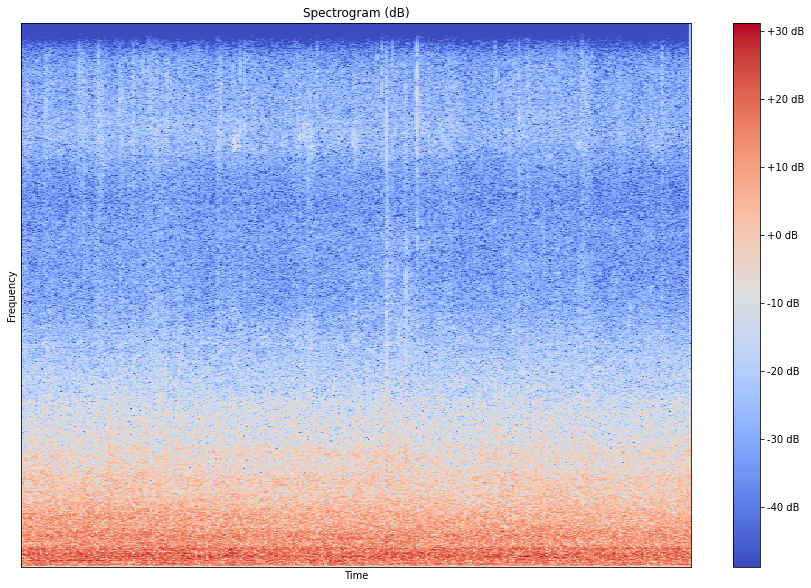

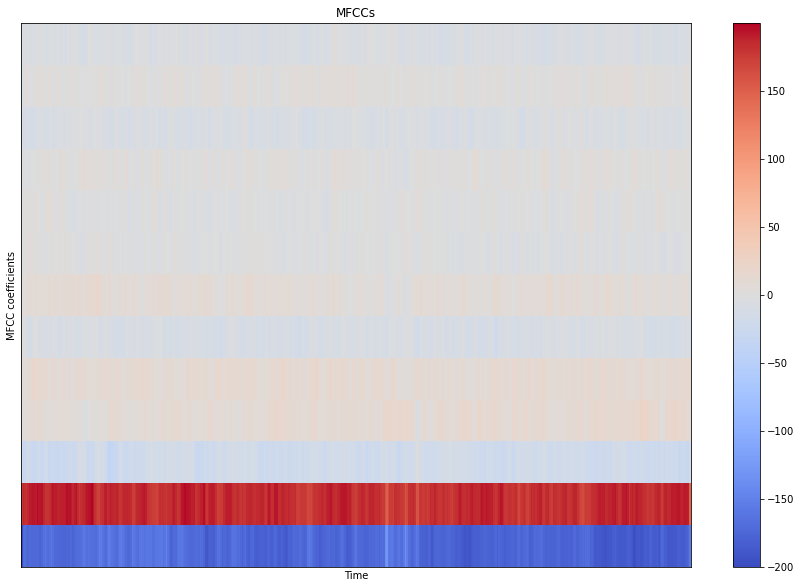

In [48]:
FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")


# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")


# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")


# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
